In [1]:
# Import library and module
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
import matplotlib.pyplot as plt
from pypfopt import risk_models, expected_returns, plotting
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

Summary:
1. Prepare historical asset price data by crawling data from cophieu68.vn
2. Choosing time period and Summary DataFrame
3. Visualize Portfolio Close Price History
4. Calculate Covariance matrix, Portfolio Expected Return, Standard Deviation, Variance
5. Find the optimal portfolio with Max Sharpe Ratio
6. Portfolio allocation

## 1. Prepare historical asset price data by crawling data from cophieu68.vn

### Get list url from stocks list

In [2]:
base_url = 'https://www.cophieu68.vn/historyprice.php?currentPage='
list_stock = ['KDC', 'DHG', 'VCB']        # insert stock name to get data
nested_list=[]
list_url = []

for stock in range(0,len(list_stock)):
    print('Getting link: ', list_stock[stock])
    global nested_list
    for page in range(1,100):
        item = base_url + str(page) + '&id=' + str(list_stock[stock].lower())
        nested_list.append(item)
    list_url.append(nested_list)
    nested_list=[]      # reset variable

Getting link:  KDC
Getting link:  DHG
Getting link:  VCB


### Crawling historical close price from cophieu68.vn

In [3]:
data = pd.DataFrame(columns= list_stock)
close_price = []
date_list = []

for stock in range(0,len(list_stock)):                              # call 3 stock
    print(f'Stock: {list_stock[stock]}. Process: {stock+1}/{len(list_stock)}')
    global close_price
    global date_list
    for link in range(0,len(list_url[0])):                          # get all page of 1 stock
        # print('Counter: ', link)
        response = requests.get(list_url[stock][link])
        soup = BeautifulSoup(response.text, 'html.parser')
        table = soup.find_all('table')
        tr_data =table[1].find_all('tr')
        for row in tr_data[1:]:                                     # get all row of 1 page
            td_list = row.find_all('td')
            try:
                close = td_list[5].text.strip()
                close_price.append(close)
                date = td_list[1].text.strip()
                date_list.append(date)
            except IndexError:
                pass
    data.iloc[:,stock] = pd.Series(close_price)
    close_price = []

data['date'] = pd.Series(date_list)
data.set_index('date', inplace=True)
data.index = pd.to_datetime(data.index, format='%d-%m-%Y')
data = data.iloc[::-1] # reverse dataframe
print('Finish')

Stock: KDC. Process: 1/3
Stock: DHG. Process: 2/3
Stock: VCB. Process: 3/3
Finish


## 2. Choosing time period and Summary DataFrame

In [15]:
for stock in data.columns:
    data[stock] = pd.to_numeric(data[stock])

# Choosing time period
start = '31-10-2018'
end = '30-9-2020'
my_stocks = data.loc[start : end]
print(my_stocks)
print(my_stocks.info())

              KDC    DHG    VCB
date                           
2018-10-31  20.41  73.32  42.32
2018-11-01  20.37  73.14  41.86
2018-11-02  20.33  73.14  42.78
2018-11-05  20.29  72.44  43.00
2018-11-06  20.25  74.19  42.47
...           ...    ...    ...
2020-09-24  32.20  98.84  66.12
2020-09-25  32.28  97.82  66.04
2020-09-28  32.07  98.66  66.04
2020-09-29  31.63  98.56  64.97
2020-09-30  31.63  98.19  64.58

[479 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 479 entries, 2018-10-31 to 2020-09-30
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   KDC     479 non-null    float64
 1   DHG     479 non-null    float64
 2   VCB     479 non-null    float64
dtypes: float64(3)
memory usage: 15.0 KB
None


## 3. Visualize Portfolio Close Price History

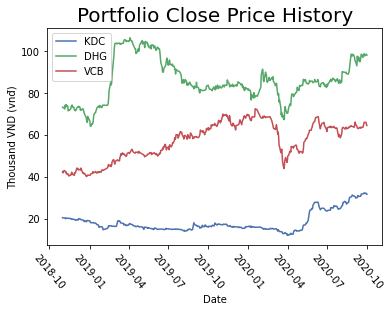

In [14]:
title = 'Portfolio Close Price History'

for c in my_stocks.columns:
    plt.plot(my_stocks[c], label = c)
plt.title(title, fontsize= 20)
plt.xlabel('Date', fontsize = 10 )
plt.ylabel('Thousand VND (vnđ)', fontsize = 10)
plt.legend(my_stocks.columns, loc= 'upper left')
plt.xticks(rotation=-50)
plt.show()

## 4. Calculate Covariance matrix

In [16]:
# Show the simple percentage daily return
returns = my_stocks.pct_change().dropna()
returns

,KDC,DHG,VCB
date,,,
2018-11-01,-0.001960,-0.002455,-0.010870
2018-11-02,-0.001964,0.000000,0.021978
2018-11-05,-0.001968,-0.009571,0.005143
2018-11-06,-0.001971,0.024158,-0.012326
2018-11-07,-0.017284,-0.011727,-0.005416
...,...,...,...
2020-09-24,-0.001241,0.001824,0.008234
2020-09-25,0.002484,-0.010320,-0.001210
2020-09-28,-0.006506,0.008587,0.000000


          KDC       DHG       VCB
KDC  0.108049  0.005830  0.020365
DHG  0.005830  0.065388  0.016370
VCB  0.020365  0.016370  0.072394


(array([0, 1, 2]), [Text(0, 0, 'KDC'), Text(0, 1, 'DHG'), Text(0, 2, 'VCB')])

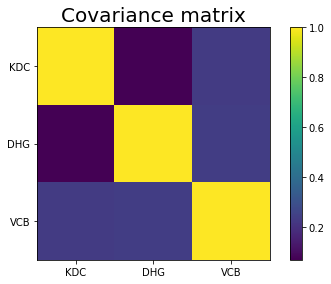

In [17]:
# create the annualized covariance matrix
plt.style.use('seaborn-deep')
cov_matrix_annual = returns.cov() * 252 # numbers of trading day
print(cov_matrix_annual)
plotting.plot_covariance(cov_matrix_annual,plot_correlation=True)
plt.title('Covariance matrix', fontsize= 20)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)

## 5. Calculate Portfolio Variance,  Standard Deviation,  Expected Return. <br> Find the optimal portfolio with Max Sharpe Ratio

In [21]:
# Calculate the Porfolio Variance
weights=np.array([1/3,1/3,1/3])
port_var = np.dot(weights.T, np.dot(cov_matrix_annual,weights))
percent_var = str(round(port_var, 2))

# Average return of each stock
mu = expected_returns.mean_historical_return(my_stocks)

# Covariance matrix
S = risk_models.sample_cov(my_stocks)

# Optimize for max shape ratio
risk_free_rate = 0.02743
ef = EfficientFrontier(mu, S)
weight = ef.max_sharpe(risk_free_rate=risk_free_rate)
cleaned_weights = ef.clean_weights()

print(cleaned_weights)
print('-'*80)
print('Portfolio Variance:', percent_var)
print(ef.portfolio_performance(verbose = True, risk_free_rate=risk_free_rate))

OrderedDict([('KDC', 0.30783), ('DHG', 0.26353), ('VCB', 0.42864)])
--------------------------------------------------------------------------------
Portfolio Variance: 0.04
Expected annual return: 23.1%
Annual volatility: 19.5%
Sharpe Ratio: 1.04
(0.23082893395001014, 0.1951908166591286, 1.0420517595621097)


## 6. Portfolio Allocation

In [20]:
# Get the discrete allocation of each share per stock
lastest_price = get_latest_prices(my_stocks)
da = DiscreteAllocation(weight, lastest_price, total_portfolio_value = 100000)  # value = 100 000 000 vnđ
allocation, leftover = da.greedy_portfolio()

portfolio = pd.DataFrame(columns=['Symbol','Total Stock', 'Proportion'])
for key, value in allocation.items():
    portfolio = portfolio.append(pd.Series({
        'Symbol' : key, 
        'Total Stock': value,
        'Proportion' : str(round(value/sum(allocation.values())*100)) + '%'
    }), ignore_index=True)

print(portfolio)
print('-'*80)
print('Fund remaining: {:.0f} vnđ'.format(leftover*1000))

  Symbol Total Stock Proportion
0    VCB         664        35%
1    KDC         973        51%
2    DHG         268        14%
--------------------------------------------------------------------------------
Fund remaining: 27970 vnđ
